<a href="https://colab.research.google.com/github/itspalash/NLP/blob/main/Hate_Speech_and_Offensive_Language_Dataset_(BERT_EXP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOAD LIBRARIES

In [ ]:
!pip install kaggle
!pip install datasets transformers
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 325 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 33.9 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 136 kB 34.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.6 MB/s 
     |████████████████████████████████| 212 kB 49.2 MB/s 
     |████████████████████████████████| 127 kB 46.8 MB/s 
     |████████████████████████████████| 596 kB 43.1 MB/s 
     |████████████████████████████████| 6.6 MB 32.6 MB/s 
     |████████████████████████████████| 895 kB 45.0 MB/s 
     |████████████████████████████████| 144 kB 39.9 MB/s 
     |████████████████████████████████| 271 kB 45.3 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [ ]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

LOAD DATASET FROM KAGGLE

In [ ]:
! kaggle datasets download mrmorj/hate-speech-and-offensive-language-dataset

  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 115MB/s]


In [ ]:
! unzip hate-speech-and-offensive-language-dataset

Archive:  hate-speech-and-offensive-language-dataset.zip
  inflating: labeled_data.csv        


DATASET EXPLORING

In [53]:
import pandas as pd

pd_data = pd.read_csv('labeled_data.csv')

#Only Tweets
def tweet_only(text):
  if ":" in text:
    return text[text.index(':')+2:len(text)]
  return text
pd_data['tweet'] = pd_data.apply(lambda x: tweet_only(x['tweet']),axis=1)



train=pd_data.sample(frac=0.7,random_state=200) #random state is a seed value
test=pd_data.drop(train.index)

In [54]:
train["class"].unique()

array([1, 2, 0])

CHECKING MISSING VALUES (FOUND NONE)

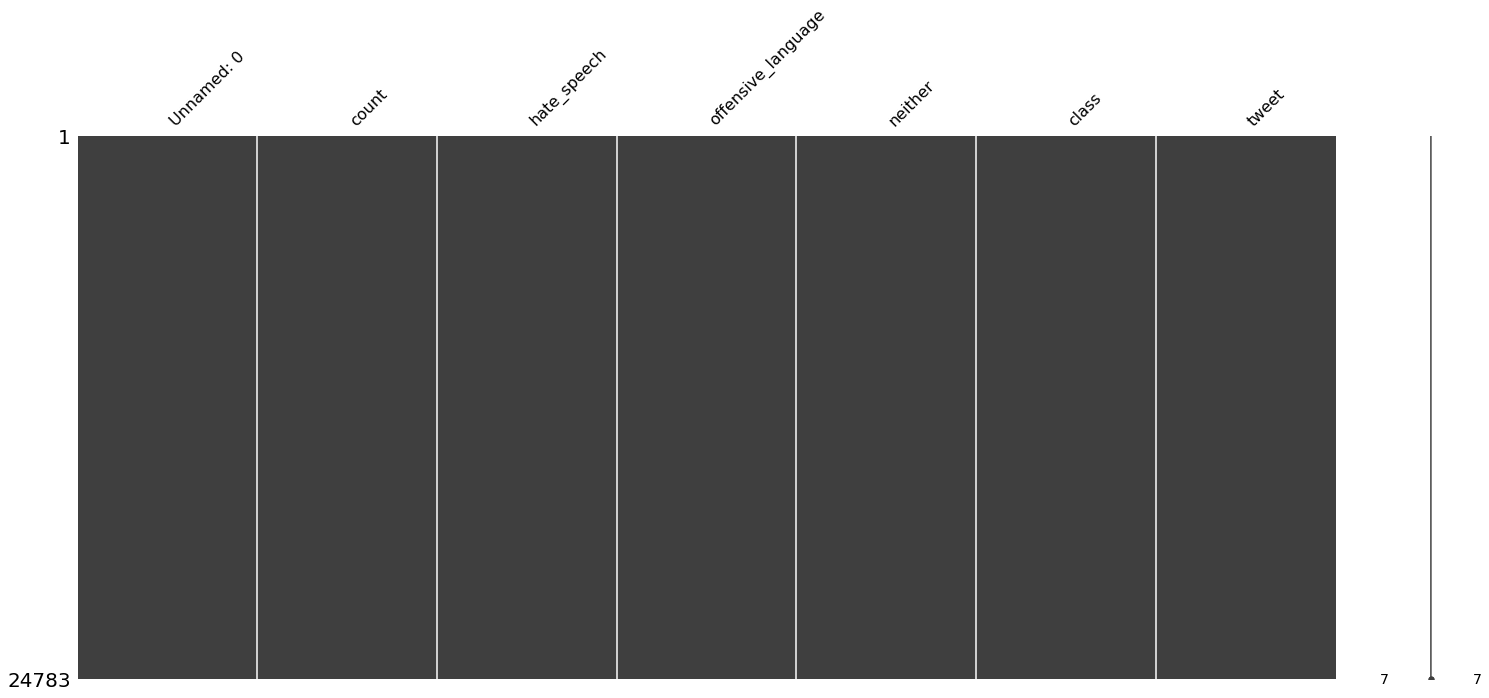

In [55]:
import missingno as msno
msno.matrix(pd_data)

BERT BEGINS

In [56]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


In [57]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [58]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [59]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [60]:
data_train = {"tweet": tf.ragged.constant(train['tweet'].to_numpy()),
        "class": tf.ragged.constant(train['class'].to_numpy())}
data_test = {"tweet": tf.ragged.constant(test['tweet'].to_numpy()),
        "class": tf.ragged.constant(test['class'].to_numpy())}

In [61]:
def bert_encode(data, tokenizer):

  tweet = tf.ragged.constant([encode_sentence(s) for s in data["tweet"]])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweet.shape[0]
  input_word_ids = tf.concat([cls, tweet], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_tweet = tf.zeros_like(tweet)
  input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [62]:
bert_data_train = bert_encode(data_train, tokenizer)
bert_data_train_labels = data_train["class"] 

bert_data_test = bert_encode(data_test, tokenizer)
bert_data_test_labels = data_test["class"] 

In [63]:
train

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
825,842,3,0,3,0,1,LA = palm trees and great weather \nAny were e...
16771,17156,3,0,3,0,1,The face you make when you see a hoe trying to...
23625,24119,3,0,3,0,1,bitch get off my twitter hoe &#128074;
10106,10379,3,0,3,0,1,I can taste loud n pussy on my tongue &#128541;
8715,8958,3,0,0,3,2,Colorado health officials recommend pot browni...
...,...,...,...,...,...,...,...
7110,7309,3,2,1,0,0,@t5_harris Are you working on route running an...
7043,7240,3,0,3,0,1,@skyereyes_ @Feebito_23 right because as far a...
8389,8622,3,0,3,0,1,Catch this jet hoe
5420,5578,3,0,3,0,1,@_puderbaugh don't be a bitch. Get two.


MODEL

In [64]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [65]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=3)

In [66]:
bert_classifier.summary()

Model: "bert_classifier_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 bert_encoder_5 (BertEncoder)   [(None, None, 768),  109482240   ['input_word_ids[0][0]',         
                                 (None, 768)]                     'input_mask[0][0

In [67]:
batch = {key: val[:10] for key, val in bert_data_train.items()}

results = bert_classifier(
    batch, training=False
).numpy()
results

array([[-0.01491722, -0.00850003,  0.15321915],
       [-0.00248923,  0.03387268,  0.1823553 ],
       [-0.03833717,  0.00100233,  0.11333068],
       [ 0.00044939,  0.03231084,  0.12976857],
       [-0.00874517,  0.02271666,  0.16913468],
       [-0.00602459,  0.04885681,  0.15976395],
       [-0.01121321,  0.00761001,  0.11252534],
       [-0.02421871,  0.03783739,  0.1483159 ],
       [-0.04083563,  0.03329666,  0.1459717 ],
       [-0.01521259,  0.02410083,  0.16938092]], dtype=float32)

In [68]:
batch


{'input_mask': <tf.Tensor: shape=(10, 473), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(10, 473), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(10, 473), dtype=int32, numpy=
 array([[  101,  2474,  1027, ...,     0,     0,     0],
        [  101,  1996,  2227, ...,     0,     0,     0],
        [  101,  7743,  2131, ...,     0,     0,     0],
        ...,
        [  101,  2023,  2003, ...,     0,     0,     0],
        [  101, 13736,  7743, ...,     0,     0,     0],
        [  101,  2023,  7743, ...,     0,     0,

In [69]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [76]:
epochs = 1
batch_size = 8
eval_batch_size = 8

train_data_size = len(bert_data_test_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [78]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

     
bert_classifier.fit(
      bert_data_train, bert_data_train_labels,
      batch_size=8,
      epochs=1)

2169/2169 [==============================] - 3755s 2s/step - loss: 0.3385 - accuracy: 0.8866


In [79]:
bert_classifier.save_weights('checkpoints/my_checkpoint')

In [80]:
import shutil
shutil.make_archive("checkpoints_Hate_Speech", 'zip', "checkpoints")

'/content/checkpoints_Hate_Speech.zip'

In [99]:
batch = {key: val[:10] for key, val in bert_data_train.items()}

results = bert_classifier(
    batch, training=False
).numpy()
batch_tweet = train["tweet"].head(10).to_numpy()
batch_real_class = train["class"].head(10).to_numpy()

for i in range(len(results)):
  print(tf.argmax(results[i]).numpy(),batch_real_class[i],batch_tweet[i])


1 1 LA = palm trees and great weather 
Any were else = horrible weather and no bitches&#8221;
1 1 The face you make when you see a hoe trying to preach on twitter http://t.co/2T1UkUDQBw
1 1 bitch get off my twitter hoe &#128074;
1 1 I can taste loud n pussy on my tongue &#128541;
2 2 Colorado health officials recommend pot brownie ban http://t.co/Z59oy20TMp
1 1 @LaneBelgarde @A7XDemery you Sick bitch didnt even invite me
1 1 Never hurt your Girlfriend to make a hoe happy &#128175; #djmemphis10
2 2 This is why nothing gets done. Morons like Coburn trying 2 ad a gun amendment 2 a public works bill. Push back on the #teabagger #morningjoe
1 1 Miserable bitches talk the most shit &#128514;&#9996;&#65039;
1 1 This bitch thinks its june or something @BriiiXO http://t.co/mFVCmym


In [100]:
results = bert_classifier.evaluate(bert_data_test, bert_data_test_labels, batch_size=8)

930/930 [==============================] - 487s 521ms/step - loss: 0.3300 - accuracy: 0.8958
